In [ ]:
import os
import cv2
import json
from time import time
import matplotlib.pyplot as plt

In [2]:
from vio_ort import VIO

In [3]:
# Задаём параметры: директория с данными, диапазон файлов и инициализацию VIO
set_dir = '2024_12_15_15_31_8_num_3'
json_files = sorted([f for f in os.listdir(set_dir) if f.endswith('.json')])
start = 0
count_json = len(json_files)

# Инициализация VIO (передаём начальные координаты)
odometry = VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

In [ ]:
def run_vio_with_gps(odometry, json_files, start, count_json):
    """
    Обрабатывает файлы JSON, извлекая координаты VIO и GPS (если они присутствуют).
    
    Возвращает словарь с:
		- 'lat_VIO', 'lon_VIO', 'alt_VIO': координаты, рассчитанные системой VIO (широта, долгота, высота в миллиметрах).
		- 'lat_GPS', 'lon_GPS', 'alt_GPS': GPS-координаты (широта, долгота, высота в метрах), если данные доступны. В противном случае — None.

    """
    lat_VIO, lon_VIO, alt_VIO = [], [], []
    lat_GPS, lon_GPS, alt_GPS = [], [], []

    for filename in json_files[start:start + count_json]:
        filepath = os.path.join(set_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)

            # Читаем соответствующее изображение
            img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
            image = cv2.imread(img_path)

            # Обработка VIO
            result_vio = odometry.add_trace_pt(image, data)
            lat_VIO.append(result_vio['lat'])
            lon_VIO.append(result_vio['lon'])
            alt_VIO.append(result_vio['alt'] * 1000)

            # Если доступны GPS-данные, сохраняем их
            if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
                lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                lon_GPS.append(data['GNRMC'].get('lon', 0.0))
                alt_GPS.append(data.get('GPS_RAW_INT', {}).get('alt', 0.0))

    return {
        'lat_VIO': lat_VIO,
        'lon_VIO': lon_VIO,
        'alt_VIO': alt_VIO,
        'lat_GPS': lat_GPS if lat_GPS else None,
        'lon_GPS': lon_GPS if lon_GPS else None,
        'alt_GPS': alt_GPS if alt_GPS else None,
    }

In [5]:
# Обработка данных и измерение времени
start_time = time()
result = run_vio_with_gps(odometry, json_files, start, count_json)
elapsed_time = time() - start_time
print(f"Processing time: {elapsed_time:.2f} seconds")

Processing time: 254.84 seconds


In [6]:
# Проверяем наличие GPS-данных
has_gps = (result['lat_GPS'] is not None) and (result['lon_GPS'] is not None)
if has_gps:
    gps_lat = result['lat_GPS']
    gps_lon = result['lon_GPS']
else:
    print("GPS data not available. Proceeding with VIO only.")
    gps_lat, gps_lon = None, None

vio_lat = result['lat_VIO']
vio_lon = result['lon_VIO']

In [ ]:
def transform_vio_coords(vio_lon_list, vio_lat_list, params):
    """
    Преобразует координаты VIO с использованием заданных параметров трансформации.
    
    Параметры в params должны содержать:
		- gps_lon0, gps_lat0: начальные GPS координаты,
		- vio_lon0, vio_lat0: начальные VIO координаты,
		- scale_for_lon, scale_for_lat: коэффициенты масштабирования.
    Возвращает преобразованные координаты (transformed_lon, transformed_lat).
    """
    gps_lon0 = params["gps_lon0"]
    gps_lat0 = params["gps_lat0"]
    vio_lon0 = params["vio_lon0"]
    vio_lat0 = params["vio_lat0"]
    scale_for_lon = params["scale_for_lon"]
    scale_for_lat = params["scale_for_lat"]

    transformed_lon = [(v_lat - vio_lat0) * scale_for_lon + gps_lon0 for v_lat in vio_lat_list]
    transformed_lat = [-(v_lon - vio_lon0) * scale_for_lat + gps_lat0 for v_lon in vio_lon_list]
    return transformed_lon, transformed_lat

In [8]:
# Если GPS доступны, рассчитываем параметры трансформации на основе начальных координат и средних изменений;
# Если GPS нет, используем единичное масштабирование (то есть оставляем VIO без изменений)
if has_gps:
    gps_lon0 = gps_lon[0]
    gps_lat0 = gps_lat[0]
    vio_lon0 = vio_lon[0]
    vio_lat0 = vio_lat[0]

    gps_lon_range = max(gps_lon) - min(gps_lon)
    gps_lat_range = max(gps_lat) - min(gps_lat)
    vio_lon_range = max(vio_lon) - min(vio_lon)
    vio_lat_range = max(vio_lat) - min(vio_lat)

    scale_for_lon = gps_lon_range / vio_lat_range  # Преобразование VIO широты в GPS долготу
    scale_for_lat = gps_lat_range / vio_lon_range  # Преобразование VIO долготы в GPS широту
else:
    gps_lon0, gps_lat0 = 0, 0
    vio_lon0 = vio_lon[0]
    vio_lat0 = vio_lat[0]
    scale_for_lon, scale_for_lat = 1, 1

transformation_params = {
    "gps_lon0": gps_lon0,
    "gps_lat0": gps_lat0,
    "vio_lon0": vio_lon0,
    "vio_lat0": vio_lat0,
    "scale_for_lon": scale_for_lon,
    "scale_for_lat": scale_for_lat
}

# Сохраняем параметры трансформации в JSON (опционально)
"""with open("Debugs/transformation_params.json", "w") as f:
    json.dump(transformation_params, f, indent=4)"""

'with open("Debugs/transformation_params.json", "w") as f:\n    json.dump(transformation_params, f, indent=4)'

In [ ]:
# Применяем трансформацию к координатам VIO, чтобы они соответствовали масштабу GPS.
transformed_lon, transformed_lat = transform_vio_coords(vio_lon, vio_lat, transformation_params)
result['lon_VIO_transformed'] = transformed_lon
result['lat_VIO_transformed'] = transformed_lat

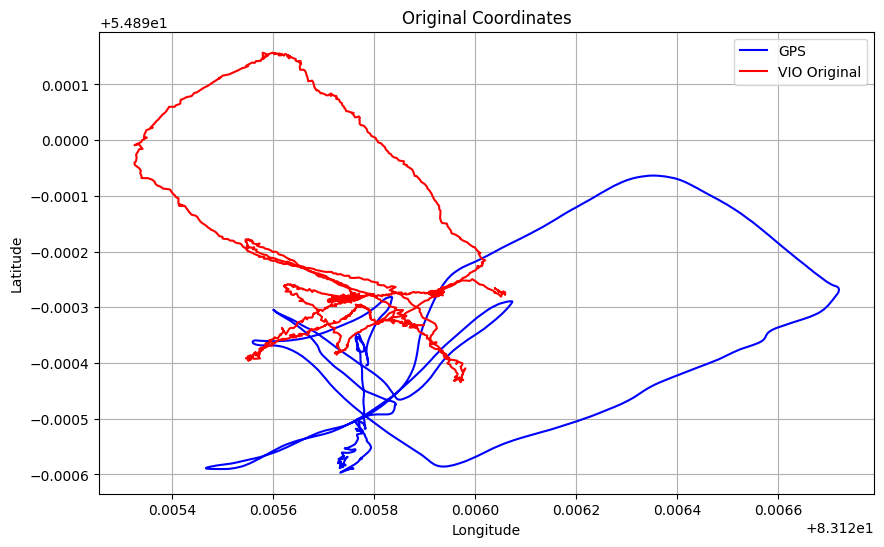

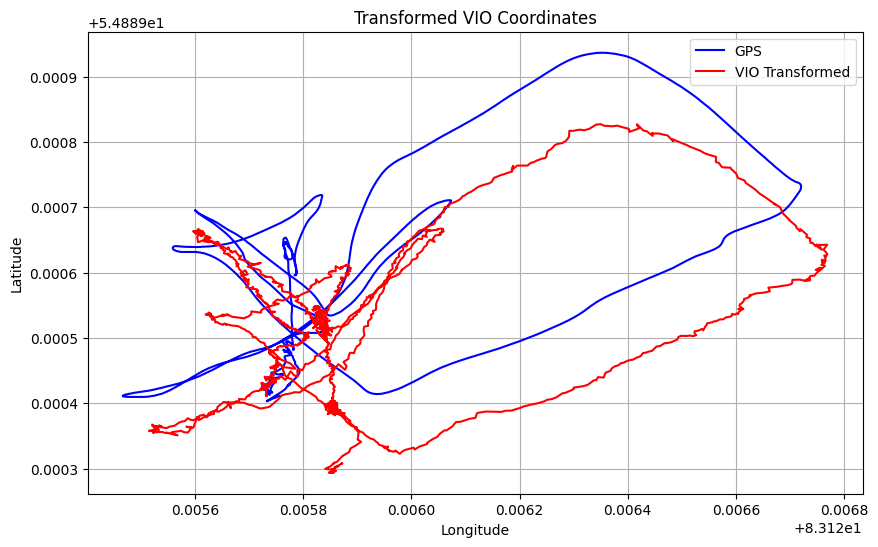

In [ ]:
# Построение графиков
# График 1: Исходные координаты (VIO и, если есть, GPS)
plt.figure(figsize=(10, 6))
if has_gps:
    plt.plot(gps_lon, gps_lat, label="GPS", color="blue")
plt.plot(vio_lon, vio_lat, label="VIO Original", color="red")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Original Coordinates")
plt.legend()
plt.grid()
plt.show()

# График 2: Трансформированные координаты VIO
plt.figure(figsize=(10, 6))
if has_gps:
    plt.plot(gps_lon, gps_lat, label="GPS", color="blue")
plt.plot(transformed_lon, transformed_lat, label="VIO Transformed", color="red")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transformed VIO Coordinates")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Нулевая координата по lon {transformed_lon[0]}")
print(f"Нулевая координата по lat {transformed_lat[0]}")
if has_gps:
    print(f"Разница начальных точек (vio - gps)(lon, lat) {transformed_lon[0] - gps_lon[0], transformed_lat[0] - gps_lat[0]}")
    print(f"Разница конечных точек (vio - gps)(lon, lat) {transformed_lon[-1] - gps_lon[-1], transformed_lat[-1] - gps_lat[-1]}")

83.1257321667
54.8894115
0.0 0.0
0.00011370549108846717 -0.00010219439435132927


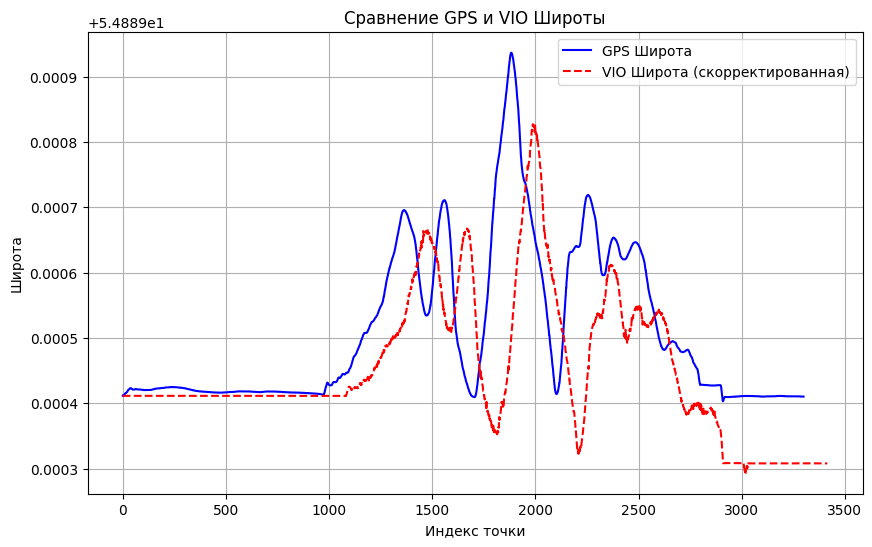

In [ ]:
plt.figure(figsize=(10, 6))
if has_gps:
	plt.plot(gps_lat, label="GPS Широта", color="blue")
plt.plot(transformed_lat, label="VIO Широта (скорректированная)", color="red", linestyle="--")
plt.xlabel("Индекс точки")
plt.ylabel("Широта")
plt.legend()
plt.title("Сравнение GPS и VIO Широты")
plt.grid()
plt.show()

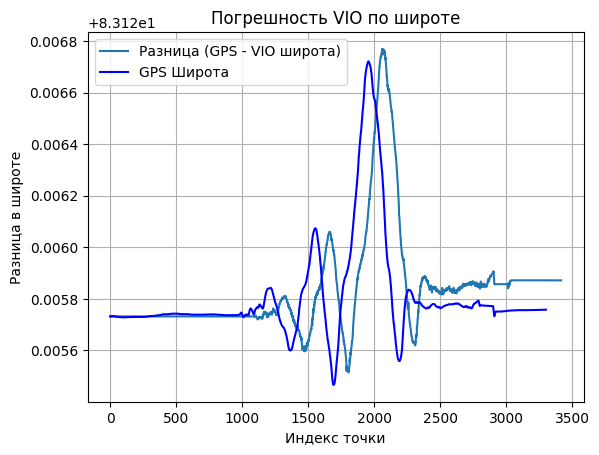

In [ ]:
plt.plot(transformed_lon, label="Разница (GPS - VIO долгота)")
if has_gps:
	plt.plot(gps_lon, label="GPS Долгота", color="blue")
plt.xlabel("Индекс точки")
plt.ylabel("Разница в долготе")
plt.legend()
plt.title("Погрешность VIO по долготе")
plt.grid()
plt.show()

Как получены константы transformation_params.json

In [ ]:
if has_gps:
	gps_lat = result['lat_GPS'].copy()
	gps_lon = result['lon_GPS'].copy()

	gps_lon0 = gps_lon[0]
	gps_lat0 = gps_lat[0]

	gps_lon_range = max(gps_lon) - min(gps_lon)
	gps_lat_range = max(gps_lat) - min(gps_lat)

vio_lat = result['lat_VIO'].copy()
vio_lon = result['lon_VIO'].copy()

vio_lon0 = vio_lon[0]
vio_lat0 = vio_lat[0]

vio_lon_range = max(vio_lon) - min(vio_lon)
vio_lat_range = max(vio_lat) - min(vio_lat)

scale_for_lon = gps_lon_range / vio_lat_range  # VIO широта -> GPS долгота
scale_for_lat = gps_lat_range / vio_lon_range  # VIO долгота -> GPS широта

transformation_params = {
	"gps_lon0": gps_lon0,
	"gps_lat0": gps_lat0,
	"vio_lon0": vio_lon0,
	"vio_lat0": vio_lat0,
	"scale_for_lon": scale_for_lon,
	"scale_for_lat": scale_for_lat
}

In [ ]:
with open("transformation_params.json", "r") as f:
    transformation_params = json.load(f)

In [16]:
def transform_vio_coords(vio_lon_list, vio_lat_list, params):
	gps_lon0 = params["gps_lon0"]
	gps_lat0 = params["gps_lat0"]
	vio_lon0 = params["vio_lon0"]
	vio_lat0 = params["vio_lat0"]
	scale_for_lon = params["scale_for_lon"]
	scale_for_lat = params["scale_for_lat"]

	transformed_lon = [(v_lat - vio_lat0) * scale_for_lon + gps_lon0 for v_lat in vio_lat_list]
	transformed_lat = [-(v_lon - vio_lon0) * scale_for_lat + gps_lat0 for v_lon in vio_lon_list]
	return transformed_lon, transformed_lat

In [17]:
vio_lon_transformed, vio_lat_transformed = transform_vio_coords(vio_lon, vio_lat, transformation_params)

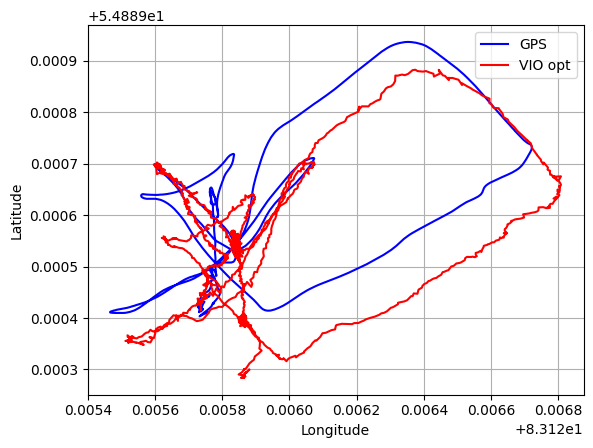

In [ ]:
# Построение графиков
vio_lon_new = vio_lon
vio_lat_new = vio_lat

if has_gps:
    plt.plot(gps_lon, gps_lat, label="GPS", color="blue")
plt.plot(vio_lon_transformed, vio_lat_transformed, label='VIO Transformed', color='red')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transformed VIO Coordinates")
plt.grid()
plt.legend()

plt.show()

In [ ]:
print(f"Нулевая координата по lon{vio_lon_transformed[0]}")
print(f"Нулевая координата по lat{vio_lat_transformed[0]}")
if has_gps:
	print(f"Разница начальных точек (vio - gps)(lon, lat){vio_lon_transformed[0] - gps_lon[0], vio_lat_transformed[0] - gps_lat[0]}")
	print(f"Разница конечных точек (vio - gps)(lon, lat){vio_lon_transformed[-1] - gps_lon[-1], vio_lat_transformed[-1] - gps_lat[-1]}")

83.1257365
54.8894156667
0.00000433329999793841, 0.00000416670000191743
0.00012262433610032986 -0.00011073132697703159


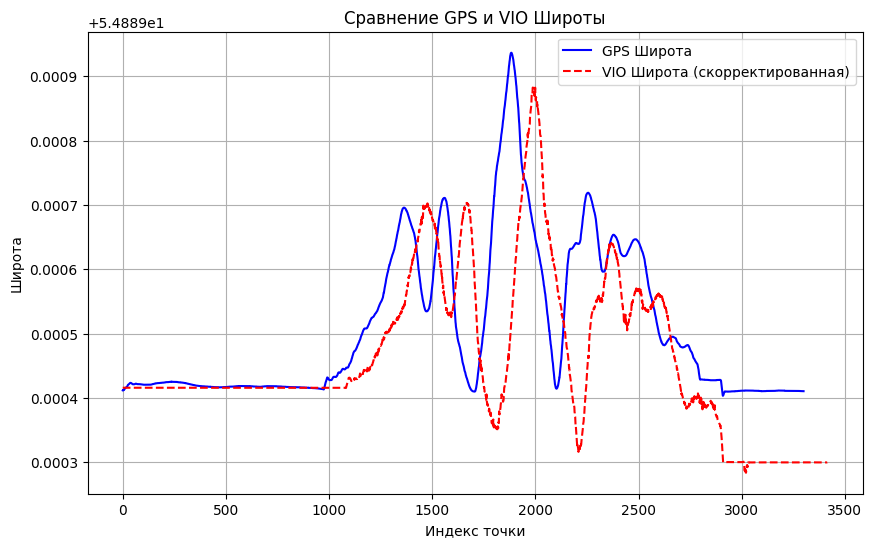

In [ ]:
plt.figure(figsize=(10, 6))
if has_gps:
	plt.plot(gps_lat, label="GPS Широта", color="blue")
plt.plot(vio_lat_transformed, label="VIO Широта (скорректированная)", color="red", linestyle="--")
plt.xlabel("Индекс точки")
plt.ylabel("Широта")
plt.legend()
plt.title("Сравнение GPS и VIO Широты")
plt.grid()
plt.show()


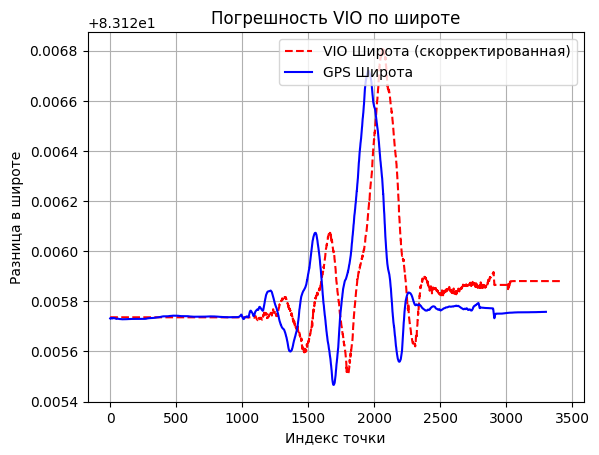

In [ ]:
plt.plot(vio_lon_transformed, label="VIO Долгота (скорректированная)", color="red", linestyle="--")
if has_gps:
	plt.plot(gps_lon, label="GPS Широта", color="blue")
plt.xlabel("Индекс точки")
plt.ylabel("Разница в долготе")
plt.legend()
plt.title("Погрешность VIO по долготе")
plt.grid()
plt.show()